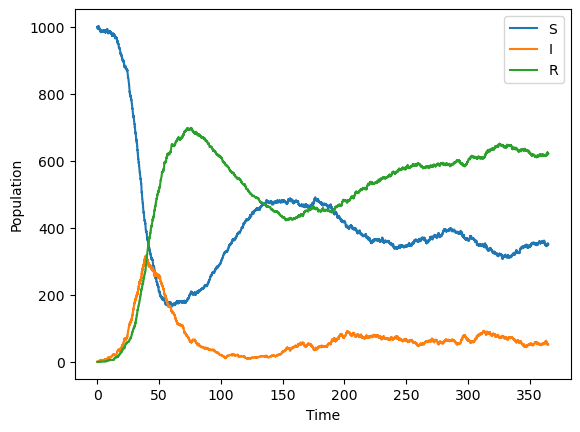

In [25]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

class Event:
    """
    Represents an event in a compartmental model, defining the dynamics 
    of disease spread among different compartments.

    Attributes:
    ----------
    name : str
        The name of the event (e.g., "infection", "recovery").
    rate : str
        A string expression that defines the rate of the event as a function 
        of various parameters (e.g., beta, gamma).
    compartments : dict
        A dictionary mapping compartment names (e.g., "S", "I", "R") 
        to their respective changes due to this event.
    """

    def __init__(self, name, rate, compartments):
        self.name = name
        self.rate = rate
        self.compartments = compartments

    def __repr__(self):
        return self.name

    def calculate(self, **kwargs):
        """
        Calculate the rate of the event using the provided parameters.

        Parameters:
        ----------
        **kwargs : dict
            Keyword arguments representing the parameters required for the 
            event rate calculation (e.g., N, S, I, R, beta, gamma, mu).

        Returns:
        -------
        float
            The calculated rate of the event based on the provided parameters.
        """
        return eval(self.rate, {}, kwargs)

    def update_compartment(self, compartment):
        """
        Update the specified compartment based on this event's defined changes.

        Parameters:
        ----------
        compartment : str
            The name of the compartment to update (e.g., "S", "I", "R").

        Returns:
        -------
        int
            The change in the specified compartment. Returns 0 if the compartment 
            does not exist in this event's compartment mapping.
        """
        try:        
            return self.compartments[compartment]
        except KeyError:
            return 0

def calc_R_total(params, events):
    """
    Calculate The rate at which any event occurs based on the current state of the compartments
    and the event list.

    Parameters:
    ----------
    params : tuple
        A tuple containing the parameters N (total population), S (susceptible), I (infected),
        R (recovered), beta (transmission rate), gamma (recovery rate), and mu (death rate).
    events : list
        A list of event objects, each of which has a calculate method to determine its contribution
        to the total rate.

    Returns:
    -------
    float
        The rate at which any event occurs by summing the contributions from each event.
    """
    N, S, I, R, beta, gamma, mu = params
    R_total = np.sum([event.calculate(N=N, S=S, I=I, R=R, beta=beta, gamma=gamma, mu=mu)
                          for event in events])
    return R_total

def gillespies(init_values, init_param, events, t_end):
    """
    Simulate the spread of an infectious disease using the Gillespie algorithm.
    Code based on the direct Gillespie algorithm mentioned by Keeling & Rohani (2011).

    Parameters:
    ----------
    init_values : tuple
        A tuple containing the initial values of the compartments: S (susceptible), I (infected),
        and R (recovered).
    init_param : tuple
        A tuple containing the initial parameters: beta (transmission rate), gamma (recovery rate),
        and mu (death rate).
    events : list
        A list of event objects that define the possible transitions between compartments.
    t_end : int
        The end time for the simulation.

    Returns:
    -------
    S_plot : list
        A list of the number of susceptible individuals at each time step.
    I_plot : list
        A list of the number of infected individuals at each time step.
    R_plot : list
        A list of the number of recovered individuals at each time step.
    t : list
        A list of the time steps at which the states were recorded.
    """
    S, I, R = init_values
    N = S + I + R
    beta, gamma, mu = init_param
    S_plot, I_plot, R_plot = [S], [I], [R]
    t = [0]
    epidemic_died = False
        
    while t[-1] < t_end:
        if (S < 0 or I < 0):
            epidemic_died = True
            return S_plot, I_plot, R_plot, t, epidemic_died

        R_total = calc_R_total((N, S, I, R, beta, gamma, mu), events)
        delta_t = (-1 / R_total) * np.log(np.random.uniform())
        t.append(t[-1] + delta_t)

        P = random.random() * R_total
        cumulative_sum = 0
        
        for index, event in enumerate(events):
            cumulative_sum += event.calculate(N=N, S=S, I=I, R=R, beta=beta, gamma=gamma, mu=mu)
            if P < cumulative_sum:
                S += event.update_compartment("S")
                I += event.update_compartment("I")
                R += event.update_compartment("R")
                break
                
        S_plot.append(S)
        I_plot.append(I)
        R_plot.append(R)   
    
    return S_plot, I_plot, R_plot, t, epidemic_died

init_values = (999, 1, 0) # S, I, R
init_param = (0.3, 0.1, 0.01) # beta, gamma, mu
t = 365

events = [
        Event(name="birth", rate="mu * N", compartments={"S": 1}),
        Event(name="infection", rate="beta * ((S * I) / N)", compartments={"S": -1, "I": 1}),
        Event(name="recovery", rate="gamma * I", compartments={"I": -1, "R": 1}),
        Event(name="death_S", rate="mu * S", compartments={"S": -1}),
        Event(name="death_I", rate="mu * I", compartments={"I": -1}),
        Event(name="death_R", rate="mu * R", compartments={"R": -1}),
    ]

S_plot, I_plot, R_plot, t_plot, epidemic_died = gillespies(init_values, init_param, events, t)

plt.plot(t_plot, S_plot, label='S')
plt.plot(t_plot, I_plot, label='I')
plt.plot(t_plot, R_plot, label='R')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

def plot_epochs(common_values, all_values, t,
               xlabel, ylabel, title):
    """
    Plots the results of the simulation over time.

    Parameters:
    ----------
    - common_values: tuple
        A tuple containing the mean values of susceptible (S), infected (I), and recovered (R) populations.
        Format: (common_S, common_I, common_R).
    - all_values: tuple
        A tuple containing lists of all values for S, I, and R across multiple simulations.
        Format: (all_S, all_I, all_R).
    - t: int
        The common time points for which the values are calculated.
    - xlabel: string
        Label for the x-axis.
    - ylabel: string
        Label for the y-axis.
    - title: string
        Title of the plot.
    """

    common_S, common_I, common_R = common_values
    all_S, all_I, all_R = all_values
    
    plt.figure(figsize=(12, 6))    
    for S, I, R in zip(all_S, all_I, all_R):
        plt.plot(common_t, S, color='gray', alpha=0.1)
        plt.plot(common_t, I, color='gray', alpha=0.1)
        plt.plot(common_t, R, color='gray', alpha=0.1)
    
    plt.plot(common_t, common_S, label='S', color='blue', linewidth=2)
    plt.plot(common_t, common_I, label='I', color='orange', linewidth=2)
    plt.plot(common_t, common_R, label='R', color='green', linewidth=2)
    
    plt.xlabel('Time (Days)')
    plt.ylabel('Total Population')
    plt.title(title)
    plt.legend()
    plt.show()

def run_epochs(N, infected_frac, events, beta, gamma, mu, epochs, t):
    """
    Runs the simulation for multiple epochs.

    Parameters:
    ----------
    - N: int
        Total population size.
    - infected_frac: float
        Initial fraction of the population that is infected.
    - events: dict
        A list of events for the simulation (e.g., "birth", "recovery").
    - beta: float
        Transmission rate.
    - gamma: float
        Recovery rate.
    - mu: float
        Death rate.
    - epochs: int
        Number of simulation runs to perform.
    - t: int
        Maximum time points at which to evaluate the populations.

    Returns:
    ----------
    - common_values: tuple
        A tuple containing the mean S, I, and R populations over all simulations.
        Format: (common_S, common_I, common_R).
    - all_values: tuple
        A tuple containing lists of all S, I, and R values across all simulations.
        Format: (all_S, all_I, all_R).
    - common_t: list
        An array of common time points across all simulations.
    """
    I = N * infected_frac
    R = 0
    S = N - (I + R)
    init_values = (S, I, R)
    init_param = (beta, gamma, mu)
    
    all_S, all_I, all_R, all_t, all_died = [], [], [], [], []
    
    for _ in range(365):
        S_plot, I_plot, R_plot, t_plot, epidemic_died = gillespies(init_values, init_param, events, t)
        all_S.append(S_plot)
        all_I.append(I_plot)
        all_R.append(R_plot)
        all_t.append(t_plot)
        all_died.append(epidemic_died)

    common_t = np.linspace(0, max(max(t) for t in all_t), 500)    
    all_S = np.array([np.interp(common_t, t, S) for S, t in zip(all_S, all_t)])
    all_I = np.array([np.interp(common_t, t, I) for I, t in zip(all_I, all_t)])
    all_R = np.array([np.interp(common_t, t, R) for R, t in zip(all_R, all_t)])
    
    # TODO use mode
    common_S = np.mean(all_S, axis=0)
    common_I = np.mean(all_I, axis=0)
    common_R = np.mean(all_R, axis=0)

    return (common_S, common_I, common_R), (all_S, all_I, all_R), common_t

def simulation(N, infected_frac, events, beta, gamma, mu, epochs, t,
               xlabel="Time (Days)", ylabel="Total Population", title="Stochastic SIR simulation"):
    """
    Conducts the SIR simulation and generates the plot of
    the results based on the Gillespies algorithm.

    Parameters:
    ----------
    - N: int
        Total population size.
    - infected_frac: float
        Initial fraction of the population that is infected.
    - events: dict
        A list of events for the simulation (e.g., "birth", "recovery").
    - beta: float
        Transmission rate.
    - gamma: float
        Recovery rate.
    - mu: float
        Death rate.
    - epochs: int
        Number of simulation runs to perform.
    - t: int
        Maximum time points at which to evaluate the populations.
    - xlabel: string
        Label for the x-axis, default is "Time (Days)".
    - ylabel: string
        Label for the y-axis, default is "Total Population".
    - title: string
        Title of the plot, default is "Stochastic SIR simulation"
    """    
    common_values, all_values, t = run_epochs(N, infected_frac, events, beta, gamma, mu, epochs, t)
    plot_epochs(common_values, all_values, t, xlabel, ylabel, title)

/var/folders/j1/92j9wgns1w1cdgc0cfvcys000000gn/T/ipykernel_60889/2060648441.py:124: RuntimeWarning: Mean of empty slice
  mean_S = np.nanmean(results_interp[:, 0, :], axis=0)
/var/folders/j1/92j9wgns1w1cdgc0cfvcys000000gn/T/ipykernel_60889/2060648441.py:125: RuntimeWarning: Mean of empty slice
  mean_I = np.nanmean(results_interp[:, 1, :], axis=0)
/var/folders/j1/92j9wgns1w1cdgc0cfvcys000000gn/T/ipykernel_60889/2060648441.py:126: RuntimeWarning: Mean of empty slice
  mean_R = np.nanmean(results_interp[:, 2, :], axis=0)


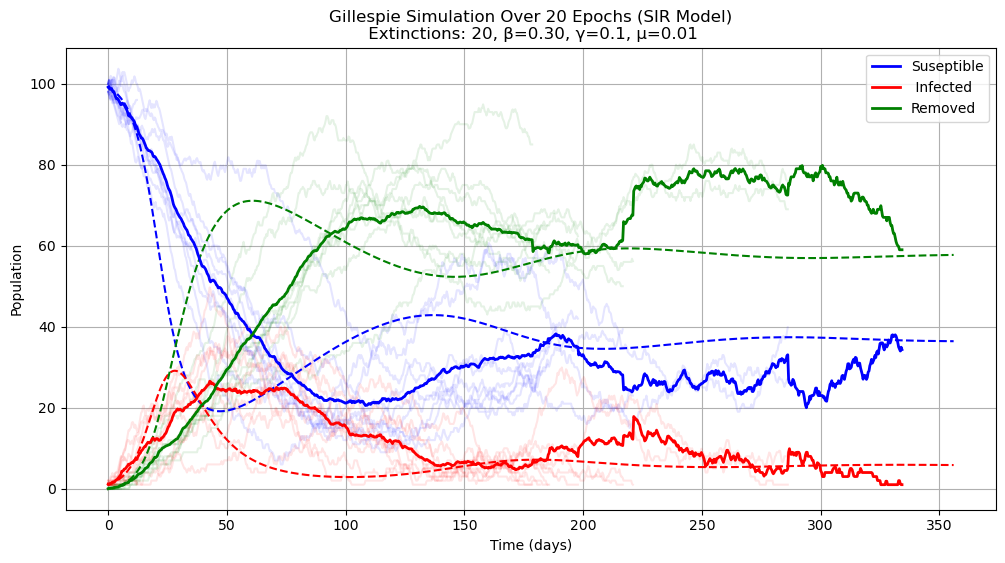

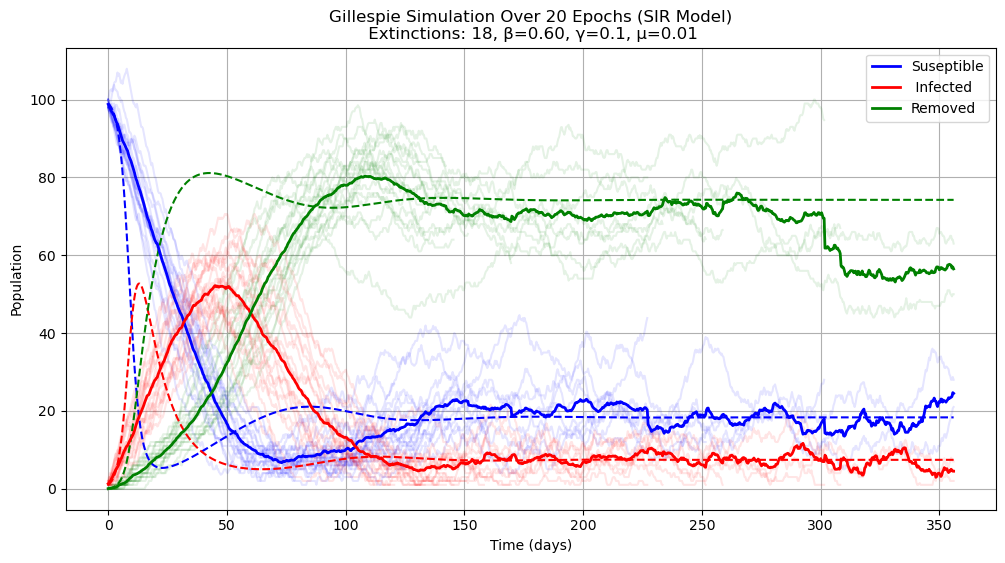

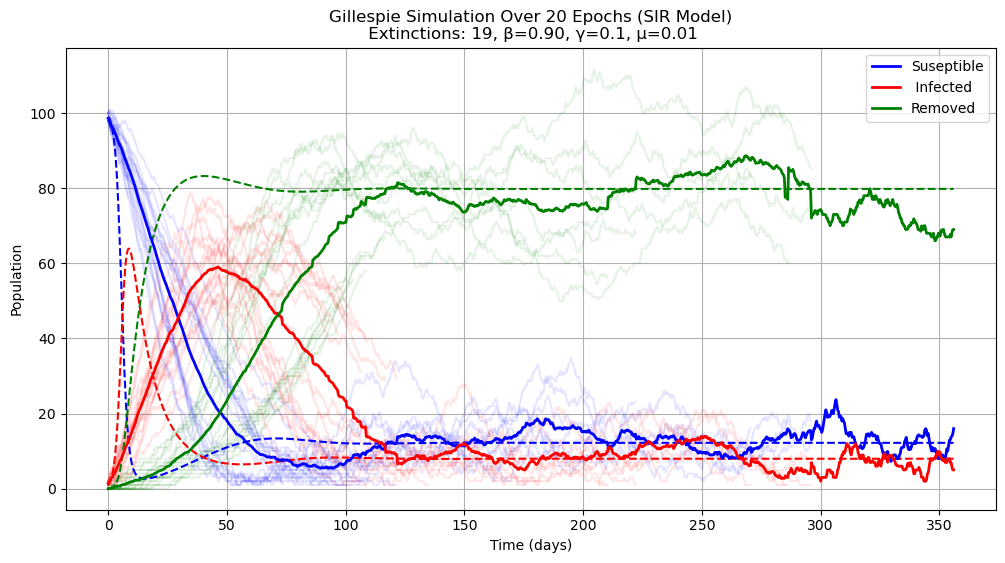

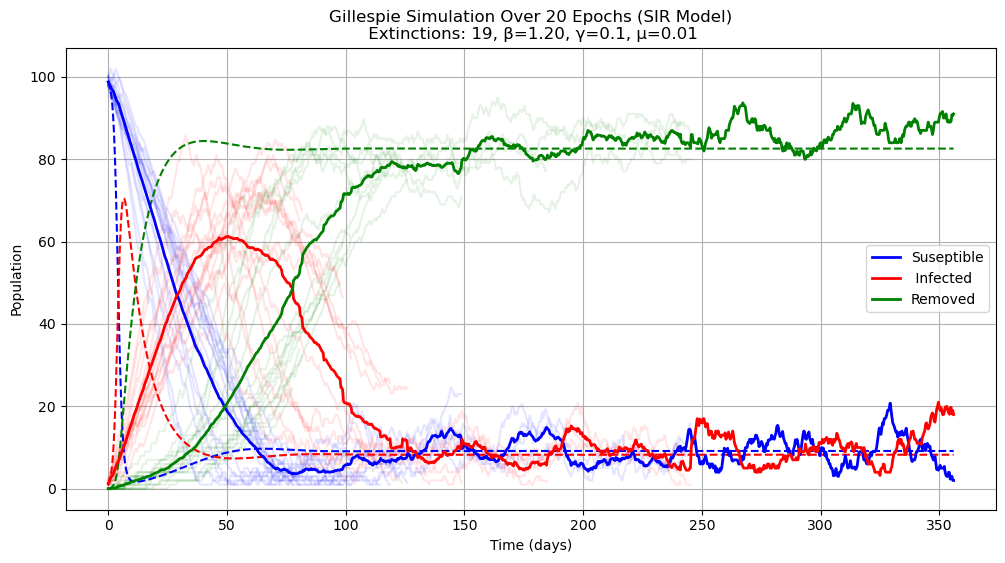

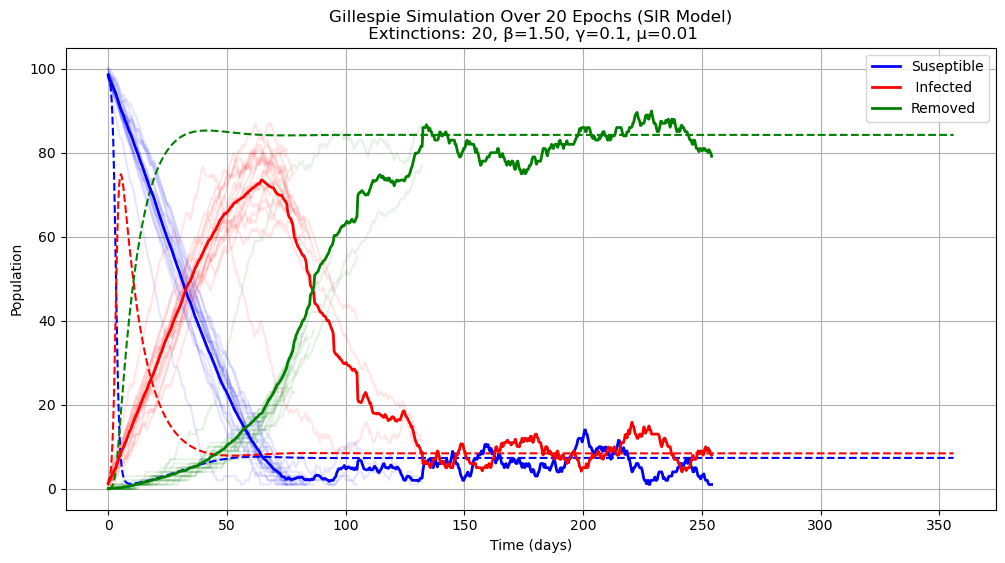

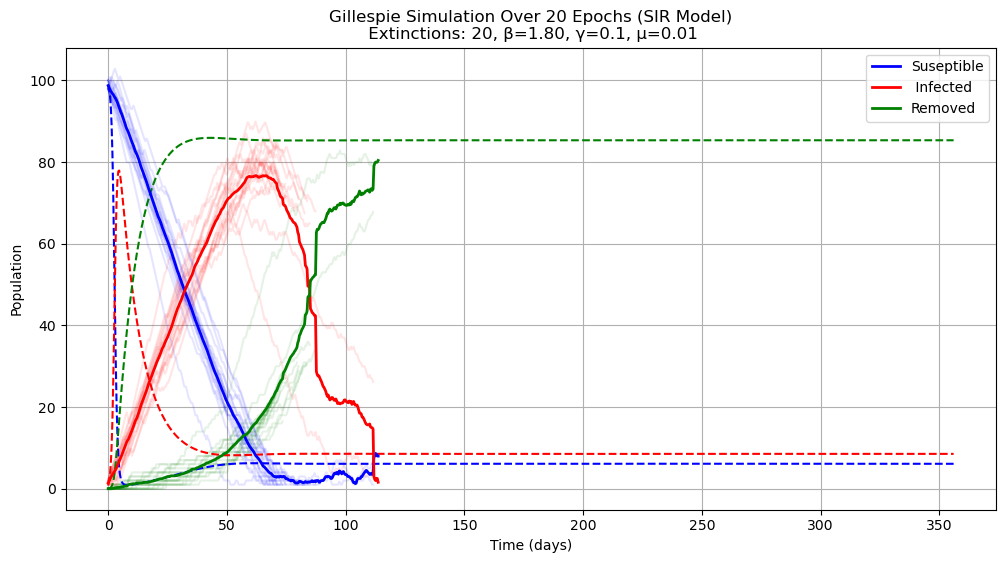

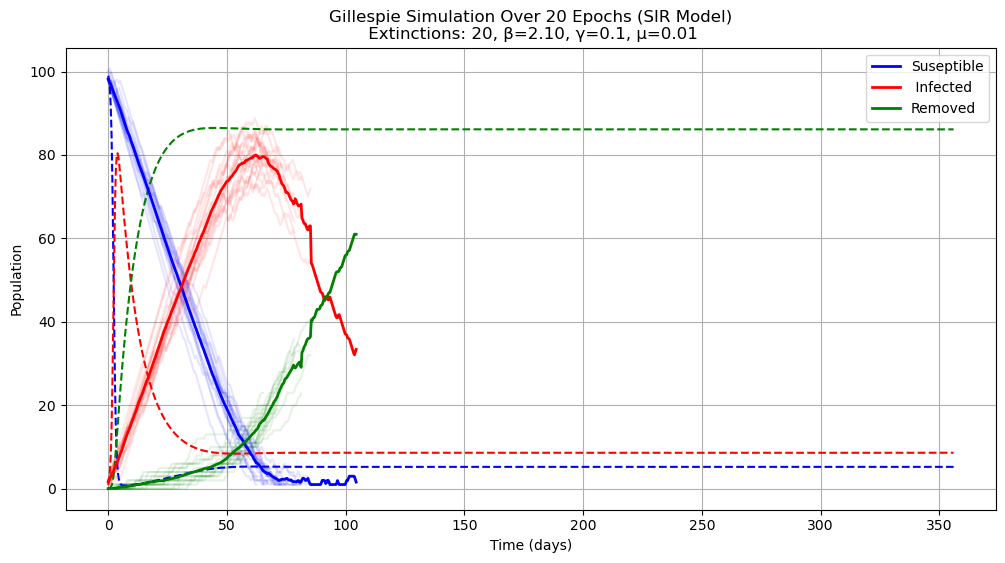

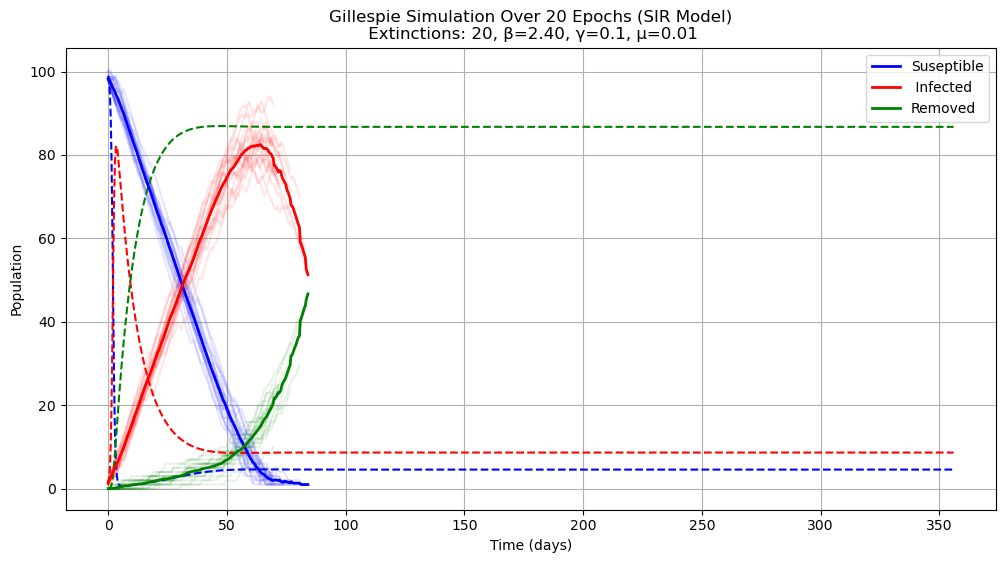

parameters: epochs=20, N=100.0, I=1.0, gamma=0.1, mu=0.01, t=356


In [74]:
# SIR model
def SIR(t, y0, N, beta, gamma, mu):
    S, I, R = y0
    dSdt = mu * N - (beta * S * I) / N - mu * S
    dIdt = (beta * S * I) / N - gamma * I - mu * I
    dRdt = gamma * I - mu * R
    return [dSdt, dIdt, dRdt]
# Gillespies helper functions
def calc_rates(N, S, I, R, beta, gamma, mu):
    return np.array([
        mu * N,             # Births                S = S + 1
        beta * S * I / N,   # Infection             S = S - 1, I = I + 1
        gamma * I,          # Recovery              I = I - 1, R = R + 1
        mu * S,             # Death of Susceptible  S = S - 1
        mu * I,             # Death of Infected     I = I - 1
        mu * R              # Death of Recovered    R = R - 1
    ])

def calc_delta_t(rates_total):
    return -np.log(np.random.uniform()) / rates_total

def calc_deterministic(t, init_values, init_param):
    t_eval = np.linspace(0, t[-1], len(t))
    sol = solve_ivp(SIR, [0, t[-1]], y0=init_values,
                    args=init_param, t_eval=t_eval, dense_output=True)
    return sol.y

def calc_interpolate(results, epochs, time_points, t):
    results_interp = np.empty((epochs, 3, len(time_points)))

    for i in range(epochs):
        history = results[i]
        if len(history) > 0:
            t_list = np.linspace(0, t, len(history))
            results_interp[i, 0, :] = np.interp(
                time_points, t_list, history[:, 0])
            results_interp[i, 1, :] = np.interp(
                time_points, t_list, history[:, 1])
            results_interp[i, 2, :] = np.interp(
                time_points, t_list, history[:, 2])

    return results_interp
def gillespie(N, S, I, beta, gamma, mu, t_max, chunk_size=1000):
    R = 0
    t_list = [0]
    extinction_event = False
    # Allocate memory for history
    history = np.empty((chunk_size, 3), dtype=float)

    step = 0
    while t_list[-1] < t_max:
        rates = calc_rates(N, S, I, R, beta, gamma, mu)
        rates_total = rates.sum()
        delta_t = np.random.exponential(1/rates_total)

        P = np.random.uniform() * rates_total
        cumulative_rates = np.cumsum(rates)

        event_index = np.searchsorted(cumulative_rates, P)

        if event_index == 0:
            if S > 0:
                S += 1
        elif event_index == 1:
            if S > 0:
                S -= 1
                I += 1
        elif event_index == 2:
            if I > 0:
                I -= 1
                R += 1
        elif event_index == 3:
            if S > 0:
                S -= 1
        elif event_index == 4:
            if I > 0:
                I -= 1
        elif event_index == 5:
            if R > 0:
                R -= 1

        # Increase the size of history if needed
        if step >= history.shape[0]:
            history = np.resize(history, (history.shape[0] + chunk_size, 3))
        history[step] = [S, I, R]

        if S <= 0 or I <= 0:
            history[step] = [np.nan, np.nan, np.nan]
            extinction_event = True

        t_list.append(t_list[-1] + delta_t)
        step += 1

    history = history[:step]
    return history, t_list, extinction_event
def simulate(epochs, N, S, I, beta, gamma, mu, t_max, chunk_size=1000):
    results = []
    extinsions = []

    for _ in range(epochs):
        history, t_list, extinsion_event = gillespie(
            N, S, I, beta, gamma, mu, t_max, chunk_size)
        results.append(history)
        extinsions.append(extinsion_event)
    
    results = np.array(results, dtype=object)
    return results, extinsions

def plot_simulation(results, extinsions, epochs, N, S, I, beta, gamma, mu, t):
    time_points = np.linspace(0, t, 1000)
    results_interp = calc_interpolate(results, epochs, time_points, t)

    plt.figure(figsize=(12, 6))
    for i in range(epochs):
        plt.plot(time_points, results_interp[i, 0, :], color='blue', alpha=0.1)
        plt.plot(time_points, results_interp[i, 1, :], color='red', alpha=0.1)
        plt.plot(time_points, results_interp[i, 2, :], color='green', alpha=0.1)

    sol = calc_deterministic(time_points, [S, I, 0], [N, beta, gamma, mu])
    plt.plot(time_points, sol[0], color='blue', linestyle='dashed')
    plt.plot(time_points, sol[1], color='red', linestyle='dashed')
    plt.plot(time_points, sol[2], color='green', linestyle='dashed')

    mean_S = np.nanmean(results_interp[:, 0, :], axis=0)
    mean_I = np.nanmean(results_interp[:, 1, :], axis=0)
    mean_R = np.nanmean(results_interp[:, 2, :], axis=0)
    plt.plot(time_points, mean_S, color='blue', label='Suseptible', linewidth=2)
    plt.plot(time_points, mean_I, color='red', label=' Infected', linewidth=2)
    plt.plot(time_points, mean_R, color='green', label='Removed', linewidth=2)

    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.title(f'Gillespie Simulation Over {epochs} Epochs (SIR Model)\n Extinctions: {sum(extinsions)}, β={beta:.2f}, γ={gamma}, μ={mu}')
    plt.grid()
    plt.legend()
    plt.show()

N = 10e1
I = N // 100
S = N - I
beta_start=0.3
beta_values = [beta_start * factor for factor in [1, 2, 3, 4, 5, 6, 7, 8]]
gamma=0.1
mu = 0.01
t = 356
epochs = 20

for i, beta in enumerate(beta_values):
    start_time = time.time()
    results, extinsions = simulate(epochs, N, S, I, beta, gamma, mu, t)
    end_time = time.time()
    ax = axes[i]
    plot_simulation(results, extinsions, epochs, N, S, I, beta, gamma, mu, t)
    ax.set_title(f"β = {round(beta,2)}, Time taken: {end_time - start_time} seconds")
    
plt.show()

print(f"parameters: epochs={epochs}, N={N}, I={I}, gamma={gamma}, mu={mu}, t={t}")



In [31]:
S_equilibrium = N*(gamma+mu)/beta 
I_equilibrium = (mu*N-S_equilibrium)/(gamma+mu)
R_equilibrium = N - S_equilibrium - I_equilibrium 